# 기타 명령어
anaconda torch_cuda env 설치된 cudnn 버전 확인
>!conda list | find "cudnn"

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import f1_score

In [2]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 64
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=4)

Files already downloaded and verified


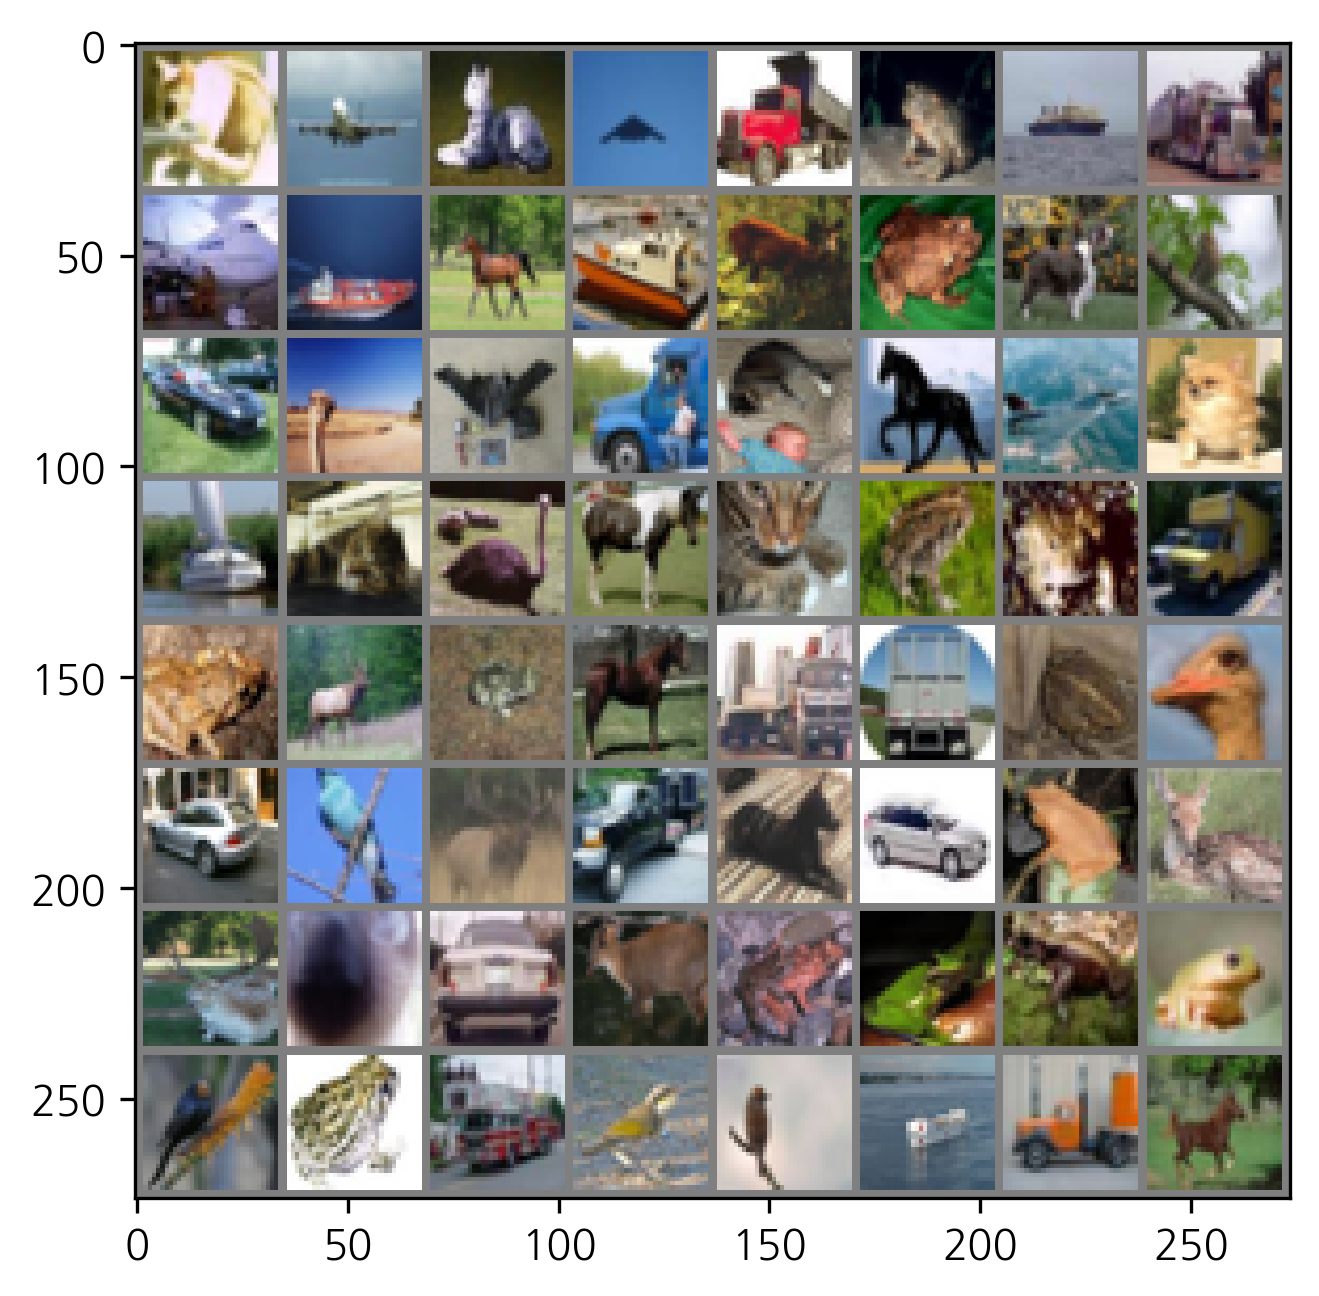

cat   plane cat   plane


In [4]:
import matplotlib.pyplot as plt
# import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [5]:
# 모델 정의
model = torchvision.models.resnet50(pretrained=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda:0


In [6]:
# 4. 학습용 데이터를 사용하여 신경망 학습

es = EarlyStopping()
epochs = 50

for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # cuda(gpu)로 데이터를 넘겨줘야 한다.
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        # 손실 함수의 loss 결과 값을 그래프로 보면 될 것
        # batch마다 출력하고 있으니 epoch 끝날 때 마다 평균내서 출력해야 한다.
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # EarlyStopping
    es(running_loss / i)
    print(f'[{epoch + 1}] loss: {running_loss / i:.3f}')
    # Early Stop Check
    if es.early_stop:
        break

    # F1-score 구할 때 function은 cpu에서 돌아가야 할 것
    # 다시 cpu로 가져오기 위해서 data.to('cpu')

print('Finished Training')


# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

[EarlyStopping] (Update) Best Score: 1.02718
[1] loss: 1.027
[EarlyStopping] (Patience) 1/3, Best: 1.02718, Current: 1.12881, Delta: 0.10163
[2] loss: 1.129
[EarlyStopping] (Update) Best Score: 0.77855
[3] loss: 0.779
[EarlyStopping] (Update) Best Score: 0.56096
[4] loss: 0.561
[EarlyStopping] (Patience) 1/3, Best: 0.56096, Current: 0.56697, Delta: 0.00601
[5] loss: 0.567
[EarlyStopping] (Patience) 2/3, Best: 0.56096, Current: 0.57295, Delta: 0.01199
[6] loss: 0.573
[EarlyStopping] (Update) Best Score: 0.46560
[7] loss: 0.466
[EarlyStopping] (Patience) 1/3, Best: 0.46560, Current: 0.90746, Delta: 0.44186
[8] loss: 0.907
[EarlyStopping] (Patience) 2/3, Best: 0.46560, Current: 0.48645, Delta: 0.02086
[9] loss: 0.486
[EarlyStopping] (Update) Best Score: 0.33077
[10] loss: 0.331
[EarlyStopping] (Update) Best Score: 0.26786
[11] loss: 0.268
[EarlyStopping] (Update) Best Score: 0.21441
[12] loss: 0.214
[EarlyStopping] (Patience) 1/3, Best: 0.21441, Current: 0.35370, Delta: 0.13929
[13] loss:

In [7]:
# 5. 시험용 데이터로 신경망 검사하기

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False, 
                                         num_workers=4)

dataiter = iter(testloader)
images, labels = next(dataiter)

Files already downloaded and verified


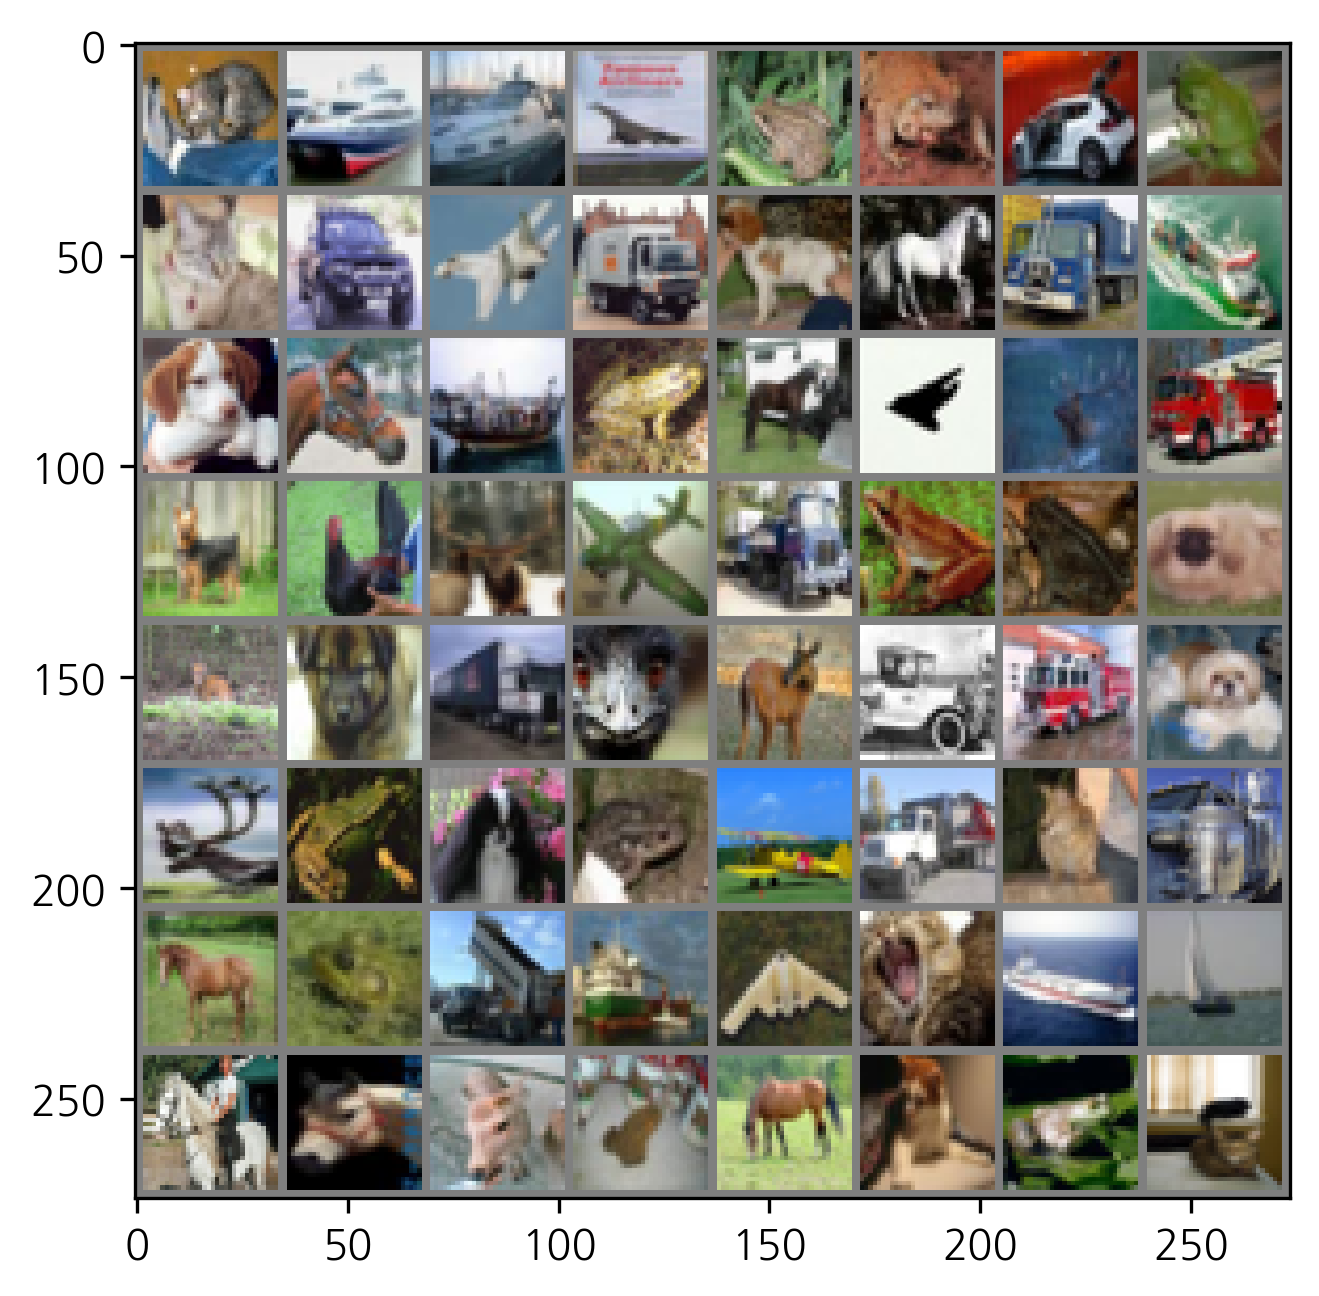

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [8]:
# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
# 저장했던 모델 불러오기
PATH = './cifar_net.pth'
model = torchvision.models.resnet50(pretrained=False)
model.load_state_dict(torch.load(PATH))
outputs = model(images)

In [10]:
# 시험용 데이터 불러오기

dataiter = iter(testloader)
images, labels = next(dataiter)

model = torchvision.models.resnet50(pretrained=True)
model.load_state_dict(torch.load(PATH))
model.eval()

# Gradients are still not needed
with torch.no_grad():
    y_true = []
    y_pred = []
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {f1:.3f}')

F1 score: 0.810


In [11]:
# 가장 높은 값을 갖는 인덱스(index)를 뽑기
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Predicted:  horse cat   ship  plane
Accuracy for class: plane is 81.6 %
Accuracy for class: car   is 89.6 %
Accuracy for class: bird  is 79.8 %
Accuracy for class: cat   is 66.4 %
Accuracy for class: deer  is 78.8 %
Accuracy for class: dog   is 70.8 %
Accuracy for class: frog  is 83.5 %
Accuracy for class: horse is 82.7 %
Accuracy for class: ship  is 92.5 %
Accuracy for class: truck is 84.2 %


# 결과 기록

- 하이퍼파라미터: 모델 학습 시 사람이 정해줘야하는 설정 값/함수 (위 코드에서 주의깊게 봐야할 사항)
    - Loss : 모델 예측값과 정답의 오차
    - Optimizer : 모델 학습 결과를 업데이트하는 방법
    - Learning Rate : 학습률. 모델 업데이트 시 반영할 비율
    - Epoch : 반복 학습 횟수
    - Batch_size : 학습 데이터를 분할하여 학습할 때 몇 개씩 할건지 정의
    
    
batch size : 64
optimizer : SGD
learning rate :  0.01
epoch : 50


1) early stopping 적용(patience 3 per loss) :  
    loss : [50] loss: 1.394
    ```
    Accuracy for class: plane is 48.0 %
    Accuracy for class: car   is 75.0 %
    Accuracy for class: bird  is 23.0 %
    Accuracy for class: cat   is 22.1 %
    Accuracy for class: deer  is 13.0 %
    Accuracy for class: dog   is 34.5 %
    Accuracy for class: frog  is 66.6 %
    Accuracy for class: horse is 66.6 %
    Accuracy for class: ship  is 51.3 %
    Accuracy for class: truck is 27.3 %
    ```
2) 미적용 :  
    loss : [50,   600] loss: 0.010  
    ```
    Accuracy for class: plane is 82.9 %
    Accuracy for class: car   is 85.0 %
    Accuracy for class: bird  is 69.9 %
    Accuracy for class: cat   is 61.4 %
    Accuracy for class: deer  is 79.4 %
    Accuracy for class: dog   is 59.6 %
    Accuracy for class: frog  is 87.5 %
    Accuracy for class: horse is 82.2 %
    Accuracy for class: ship  is 86.7 %
    Accuracy for class: truck is 83.3 %
    ```
    
    

batch size : 64  
optimizer : Adam()  
learning rate :  0.01  
epoch : 50  
```
loss : [50,   600] loss: 0.055
Accuracy for class: plane is 80.4 %
Accuracy for class: car   is 85.1 %
Accuracy for class: bird  is 58.1 %
Accuracy for class: cat   is 58.3 %
Accuracy for class: deer  is 76.0 %
Accuracy for class: dog   is 64.6 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 83.6 %
Accuracy for class: ship  is 87.2 %
Accuracy for class: truck is 84.6 %
```